In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFE, f_regression, SelectKBest
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import shap
import zipfile
import os

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Preprocessing

In [238]:
zip_path = 'NBKI_test.zip'

data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_folder)

csv_files = [file for file in os.listdir(data_folder) if file.endswith('.csv')]

dataframes = {}
for csv_file in csv_files:
    df_name = os.path.splitext(csv_file)[0] 
    csv_file_path = os.path.join(data_folder, csv_file)
    dataframes[df_name] = pd.read_csv(csv_file_path)

In [7]:
dataframes.keys()

dict_keys(['NBKI_test', 'NBKI_train', 'NBKI_y_test'])

In [14]:
dataframes['NBKI_test'].columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '123', '124', '125', '126', '127', '128', '129', '130', '131', '132'],
      dtype='object', length=134)

In [8]:
merged_test = pd.merge(dataframes['NBKI_test'], dataframes['NBKI_y_test'], on='Unnamed: 0')
merged_test['split'] = 'test'

In [9]:
full_data = pd.concat([dataframes['NBKI_train'], merged_test], ignore_index=True)
full_data['split'].fillna('train', inplace=True)
full_data.rename(columns={'Unnamed: 0': 'key_val'}, inplace=True)

In [10]:
full_data.split.value_counts()

train    30007
test     29993
Name: split, dtype: int64

In [11]:
full_data['default'] = full_data['default'].astype(int)

In [41]:
full_data

,key_val,0,1,2,3,4,5,6,7,8,...,125,126,127,128,129,130,131,132,default,split
0,48417,9,1,0,22,10,500000.0,75.0,75.0,3262,...,0,13,1096,0.125000,0.000000,0.011628,0.032787,1,0,train
1,109120,9,1,5,13,10,29983.0,22.0,22.0,2189,...,0,3,123,0.181818,0.250000,0.020408,0.000000,1,0,train
2,232425,9,1,0,15,10,730000.0,16.0,16.0,2863,...,0,5,1826,0.222222,0.000000,0.029851,0.000000,1,0,train
3,31393,7,1,0,8,10,0.0,68.0,68.0,6,...,0,0,498,0.000000,0.000000,0.000000,0.000000,0,1,train
4,47064,1,1,0,22,10,901484.0,63.0,63.0,3708,...,0,16,182,0.086957,0.000000,0.008734,0.023810,1,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,584701,7,1,6,18,11,79483.0,66.0,6.0,254,...,0,0,29628,0.000000,0.000000,0.000000,0.000000,1,0,test
59996,402816,7,1,3,29,11,27000.0,6.0,74.0,426,...,0,0,1827,0.333333,0.000000,0.105263,0.117647,1,0,test
59997,512248,7,1,0,19,11,45000.0,72.0,72.0,1836,...,0,9,29628,0.470588,1.000000,0.111765,0.238095,1,0,test
59998,505324,9,1,3,15,11,10883.0,25.0,25.0,3258,...,0,1,364,0.333333,0.000000,0.013889,0.000000,1,0,test


In [12]:
full_data.default.value_counts()

0    58062
1     1938
Name: default, dtype: int64

### Analysis of Nan values

In [13]:
missing_values = full_data.isnull().any().any()
missing_values

True

In [15]:
missing_values = full_data.isnull().sum()
print(list(missing_values))

[0, 0, 0, 0, 0, 0, 0, 2242, 2056, 0, 137, 382, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
full_data['7'].isnull().sum()

2056

In [16]:
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing # названия колонок где присутствуют пропущенные значения

['6', '7', '9', '10']

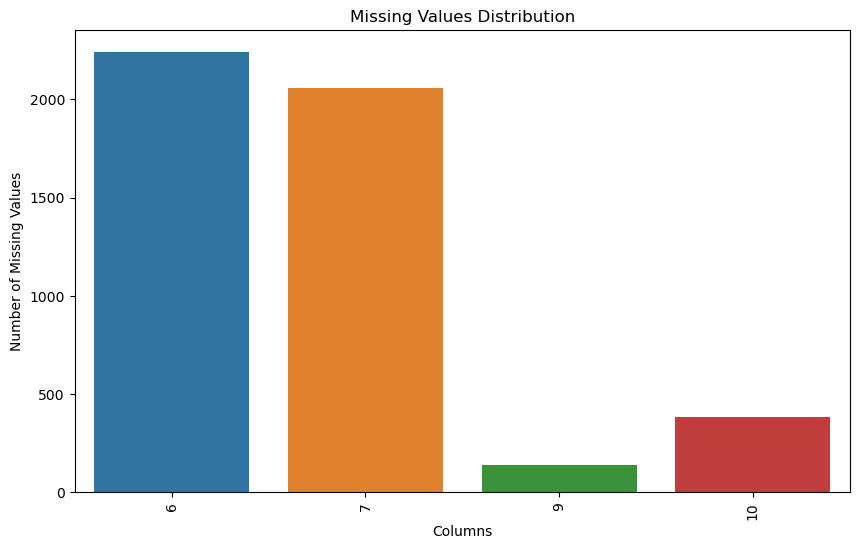

In [56]:
plt.figure(figsize=(10, 6))
sns.barplot(x=columns_with_missing, y=missing_values[columns_with_missing])
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Missing Values Distribution")
plt.show()

<Figure size 1500x1000 with 0 Axes>

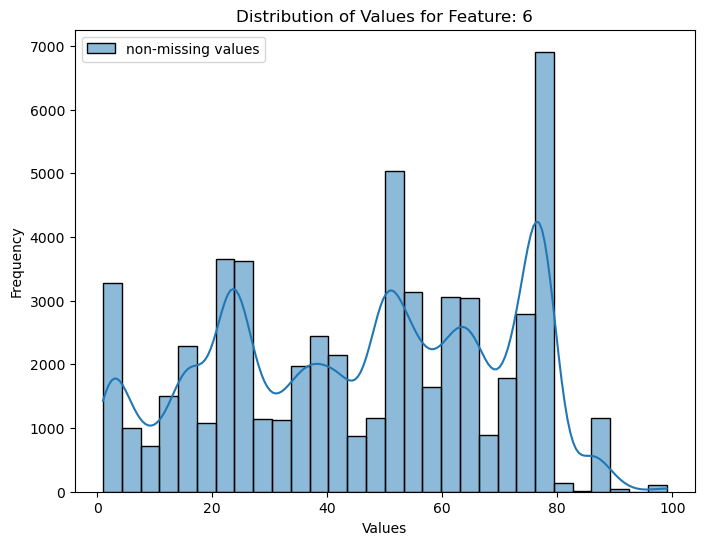

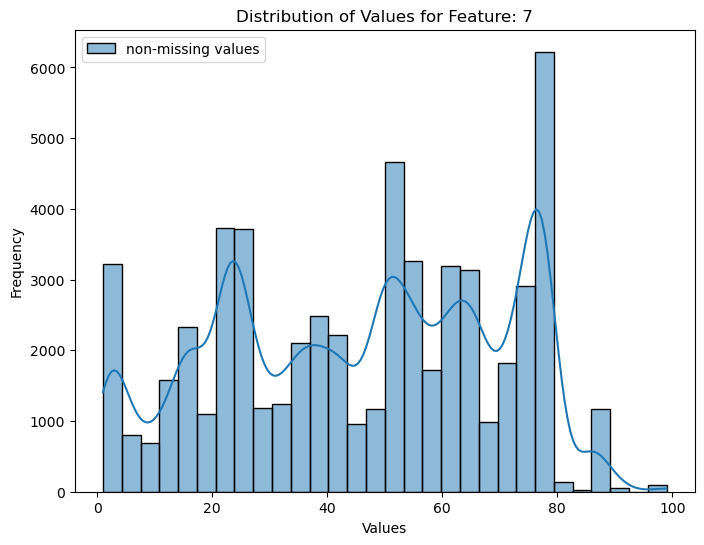

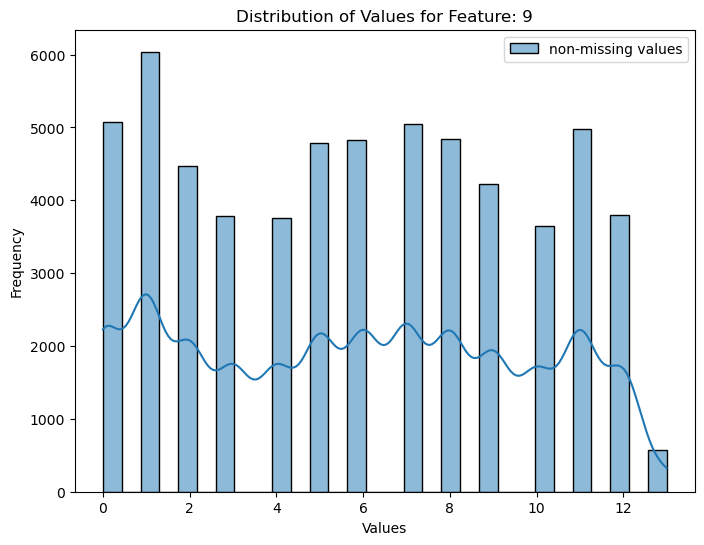

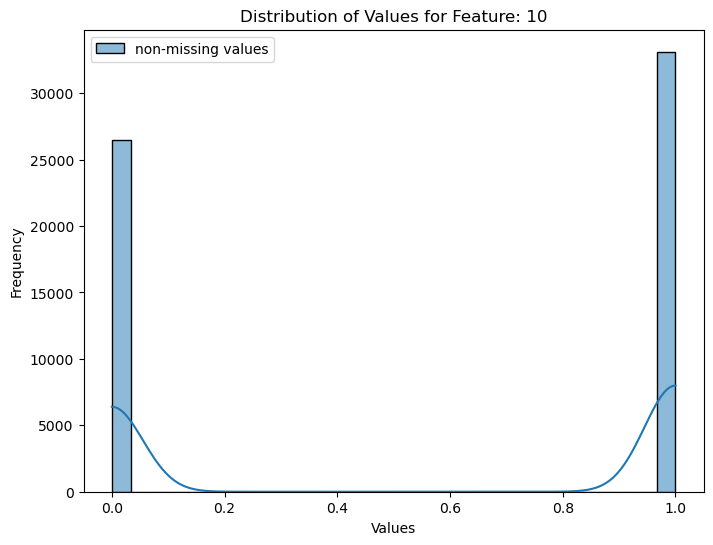

In [76]:
plt.figure(figsize=(15, 10))
for column in columns_with_missing:
    plt.figure(figsize=(8, 6))
    sns.histplot(full_data[column], bins=30, kde=True, label='non-missing values')
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.title("Distribution of Values for Feature: " + column)
    plt.legend()
    plt.show()

In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent') # замена пропусков на моду
imputed_data = full_data.copy() 
imputed_data[columns_with_missing] = imputer.fit_transform(full_data[columns_with_missing])

In [240]:
imputed_data

,key_val,0,1,2,3,4,5,6,7,8,...,125,126,127,128,129,130,131,132,default,split
0,48417,9,1,0,22,10,500000.0,75.0,75.0,3262,...,0,13,1096,0.125000,0.000000,0.011628,0.032787,1,0,train
1,109120,9,1,5,13,10,29983.0,22.0,22.0,2189,...,0,3,123,0.181818,0.250000,0.020408,0.000000,1,0,train
2,232425,9,1,0,15,10,730000.0,16.0,16.0,2863,...,0,5,1826,0.222222,0.000000,0.029851,0.000000,1,0,train
3,31393,7,1,0,8,10,0.0,68.0,68.0,6,...,0,0,498,0.000000,0.000000,0.000000,0.000000,0,1,train
4,47064,1,1,0,22,10,901484.0,63.0,63.0,3708,...,0,16,182,0.086957,0.000000,0.008734,0.023810,1,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,584701,7,1,6,18,11,79483.0,66.0,6.0,254,...,0,0,29628,0.000000,0.000000,0.000000,0.000000,1,0,test
59996,402816,7,1,3,29,11,27000.0,6.0,74.0,426,...,0,0,1827,0.333333,0.000000,0.105263,0.117647,1,0,test
59997,512248,7,1,0,19,11,45000.0,72.0,72.0,1836,...,0,9,29628,0.470588,1.000000,0.111765,0.238095,1,0,test
59998,505324,9,1,3,15,11,10883.0,25.0,25.0,3258,...,0,1,364,0.333333,0.000000,0.013889,0.000000,1,0,test


## Feature selection

In [25]:
X, y = imputed_data.drop(columns=['split', target_column]), imputed_data[target_column]

In [24]:
def get_top_correlated_features(data, target, top_n=10):
    correlations = data.corrwith(target)
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    top_features = sorted_correlations.head(top_n)
    return top_features

top_correlated_features = get_top_correlated_features(X_train, y_train, top_n=20)
print("Top Correlated Features:")
print(top_correlated_features)

Top Correlated Features:
131    0.165954
119    0.162577
121    0.146806
122    0.141112
123    0.139968
130    0.136896
120    0.135950
115    0.121643
116    0.121474
114    0.118736
124    0.101710
13     0.100279
15     0.098929
112    0.098132
14     0.095690
12     0.094730
129    0.094406
128    0.092689
103    0.089410
16     0.087526
dtype: float64


In [2]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


In [21]:
from boruta import BorutaPy

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=42)
boruta_selector.fit(X.values, y)

selected_features = X.columns[boruta_selector.support_]
print("Selected Features:")
print(selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	122
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	122
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	122
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	122
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	123
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	123
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	123
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	123
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	5

In [22]:
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['key_val', '5', '80', '100', '127', '130', '131'], dtype='object')


## Algorithm Interpretation
Confirmed: 	7
Tentative: 	0
Rejected: 	127
 - Confirmed: Кол-во признаков, которые Boruta считает уверенно считает значимыми = 7 признаков.

 - Tentative: Кол-во признаков в значимости которых алгоритм не уверен = 0 

 - Rejected: Кол-во признаков, которые Boruta считает менее значимыми или неинформативными для задачи = 127

##### Note: Здесь можно использовать множество способов выбора признаков. Это как пример

## Ради эксперимента сравним 2 деревянные модели 
    - в первом случае запредиктим для модели обученной на всех фичах
    - во втором случае используем только те фичи которые Boruta посчитала важными

In [242]:
def show_metrics(y_test, y_probs):
    
    y_pred = (y_probs >= 0.5).astype(int) 
    
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

			 Using all features
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     29055
           1       1.00      0.01      0.01       938

    accuracy                           0.97     29993
   macro avg       0.98      0.50      0.50     29993
weighted avg       0.97      0.97      0.95     29993



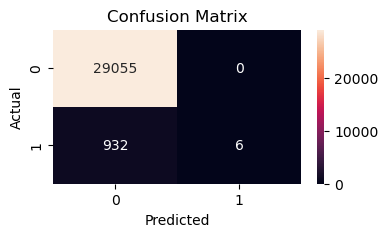


		 Using Selected Features(boruta) features
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     29055
           1       0.80      0.01      0.02       938

    accuracy                           0.97     29993
   macro avg       0.88      0.50      0.50     29993
weighted avg       0.96      0.97      0.95     29993



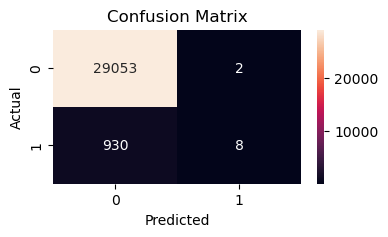

In [243]:
imp_features = ['key_val', '5', '80', '100', '127', '130', '131']

model_rfc = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# Используем все признаки
model_rfc.fit(X_train, y_train)
y_probs_base = model_rfc.predict_proba(X_test)[:, 1]
print('\t\t\t Using all features')
show_metrics(y_test, y_probs_base)

# Используем отобранные признаки
model_rfc.fit(X_train[imp_features], y_train)
y_probs_impr = model_rfc.predict_proba(X_test[imp_features])[:, 1]
print('\n\t\t Using Selected Features(boruta) features')
show_metrics(y_test, y_probs_impr)

## Result 
При уменьшении кол-ва признаков с 136 до 7 качество практически не меняется(даже имеются улучшения)

# Modeling

Рассуждения:
#### У нас имеется очень сильный дизбаланс классов, нам важно задетектить дефолт. Простой RF отработал ужасно, поэтому я предлагаю попробовать улучшить качество такими способами:
    - Использование взвешивания классов.
    - Использование алгоритмов специально предназначенных для дизбаланса (BalancedRandomForest, EasyEnsemble)
    - Использования моделей XGBoost,CatBoost,LightGBM может лучше себя показать чем RF.
    - Изменить порог принятия решения классификатором.
    
##### Note: Так как будем использовать деревянные алгоритмы и алгоритмы бустинга дополнительное масштабирование входных данных не потребуется.

In [260]:
shuffled_df = imputed_data.sample(frac=1, random_state=42) # Зашафливание данных с закреплением по сиду

train_data = shuffled_df[shuffled_df['split'] == 'train']
test_data = shuffled_df[shuffled_df['split'] == 'test']

target_column = 'default'  

X_train = train_data.drop(columns=['split', target_column])
y_train = train_data[target_column]

X_test = test_data.drop(columns=['split', target_column])
y_test = test_data[target_column]

In [253]:
from sklearn.metrics import roc_curve, auc

def get_metrics(y_test, y_probs, threshold, return_metrics=False):
    y_pred = (y_probs >= threshold).astype(int)  # Прогнозы на основе вероятностей с заданным порогом
    
    auc_score = roc_auc_score(y_test, y_probs)
    gini_auc = 2 * auc_score - 1
    
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    precision_0 = classification_rep['0']['precision']
    recall_0 = classification_rep['0']['recall']
    f1_0 = classification_rep['0']['f1-score']
    support_0 = classification_rep['0']['support']
    
    precision_1 = classification_rep['1']['precision']
    recall_1 = classification_rep['1']['recall']
    f1_1 = classification_rep['1']['f1-score']
    support_1 = classification_rep['1']['support']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    metrics_text = f"Gini (AUC): {gini_auc:.4f}\n\nClass 0:\nPrecision: {precision_0:.4f}\nRecall: {recall_0:.4f}\nF1-Score: {f1_0:.4f}\nSupport: {support_0}\n\nClass 1:\nPrecision: {precision_1:.4f}\nRecall: {recall_1:.4f}\nF1-Score: {f1_1:.4f}\nSupport: {support_1}"
    plt.text(0.5, 0.5, metrics_text, fontsize=12, ha='center', va='center')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    plt.subplot(1, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    if return_metrics:
        return gini_auc, precision_1, recall_1, f1_1

    
def validate(X_test, y_test, model, threshold=0.5, feature_to_analyze=None):
    y_probs = model.predict_proba(X_test)[:, 1]
    check = {}
    print("\t\t\tOverall Model Evaluation")
    get_metrics(y_test, y_probs, threshold)
    
    if feature_to_analyze:
        unique_values = X_test[feature_to_analyze].unique()
        for value in unique_values:
            idx = X_test[feature_to_analyze] == value
            print(f"\n\t\t Analysis by Split of Feature '{feature_to_analyze}' = {value}")
            get_metrics(y_test[idx], y_probs[idx], threshold)
            check[value] = (y_test[idx], y_probs[idx])
    return check

## CatBoostClassifier

			Overall Model Evaluation


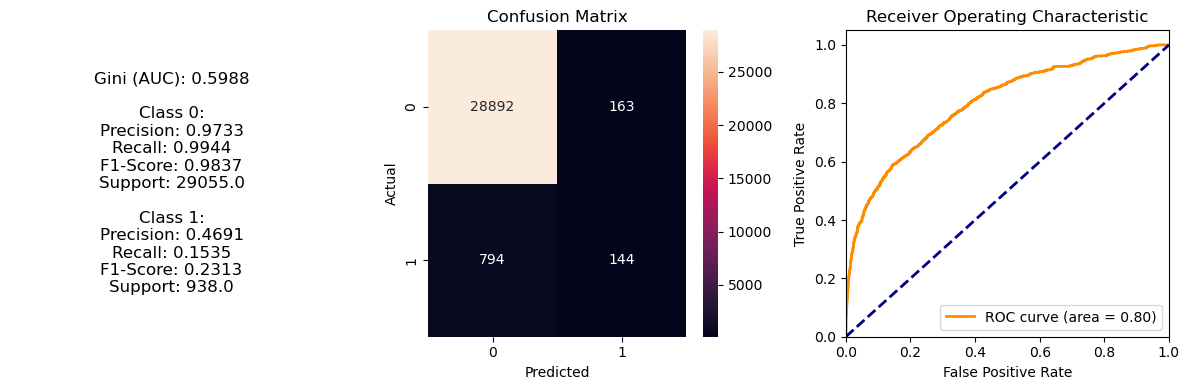


		 Analysis by Split of Feature '0' = 7


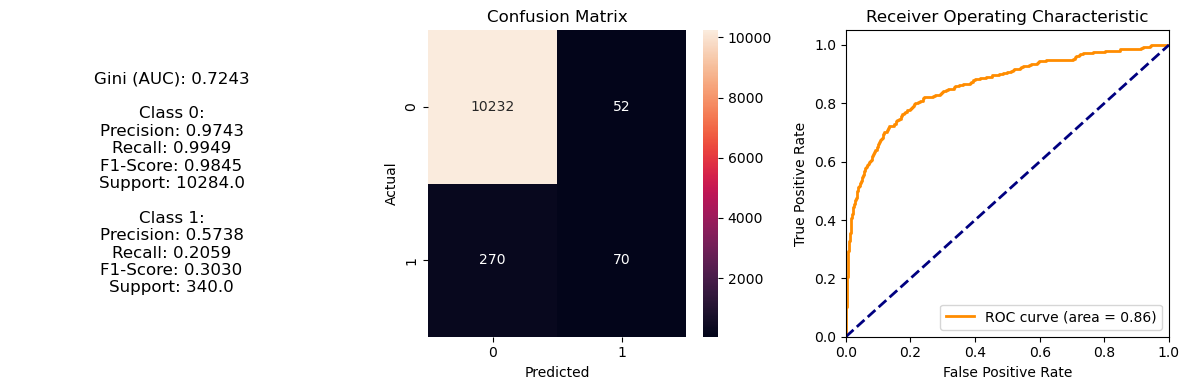


		 Analysis by Split of Feature '0' = 9


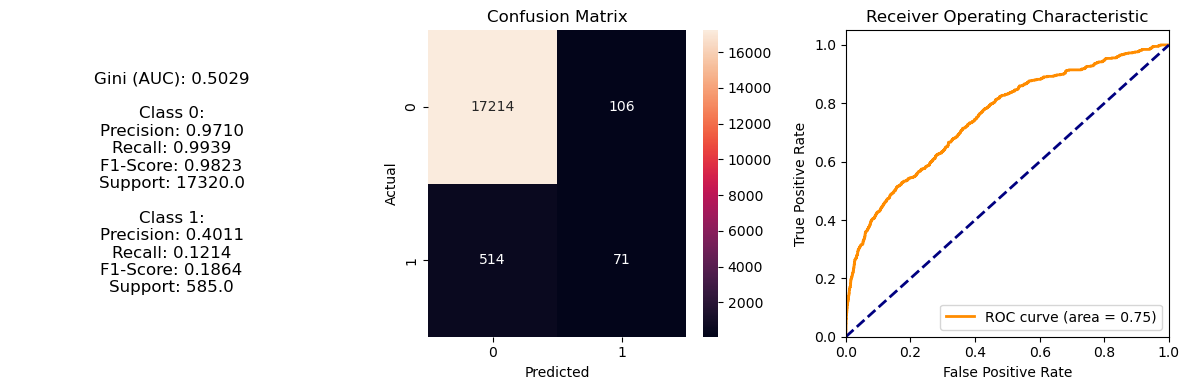


		 Analysis by Split of Feature '0' = 1


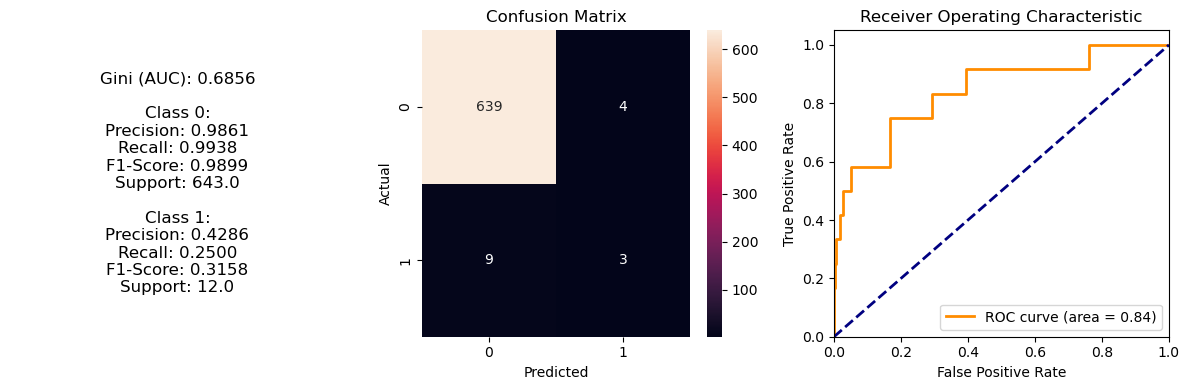

In [254]:
from catboost import CatBoostClassifier
pos_class_count = y_train.sum()
neg_class_count = len(y_train) - pos_class_count
scale_pos_weight = neg_class_count / pos_class_count #Это отношение показывает, насколько <важен> положительный класс 
                                                        #относительно отрицательного класса для обучения модели.


model_cb = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False,
                             scale_pos_weight=scale_pos_weight)
model_cb.fit(X_train, y_train)


test_check = validate(X_test, y_test, model_cb, feature_to_analyze='0')

## BalancedRandomForestClassifier

			Overall Model Evaluation


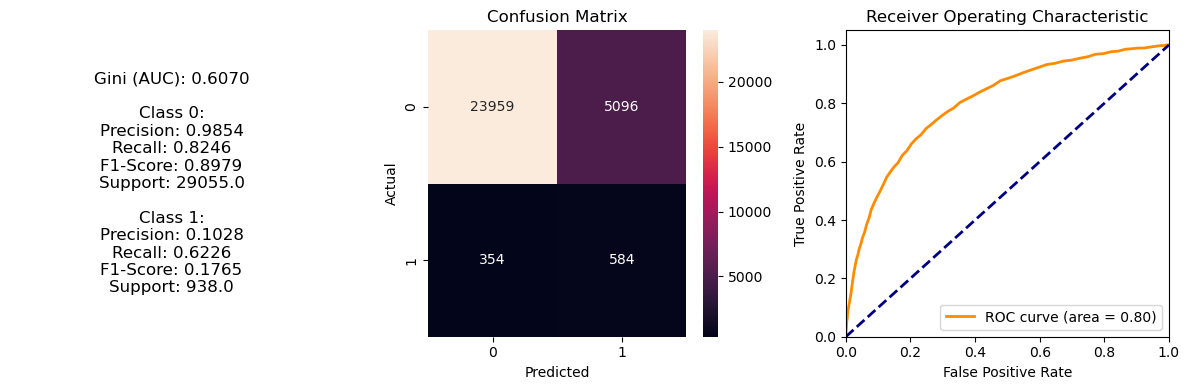


		 Analysis by Split of Feature '0' = 7


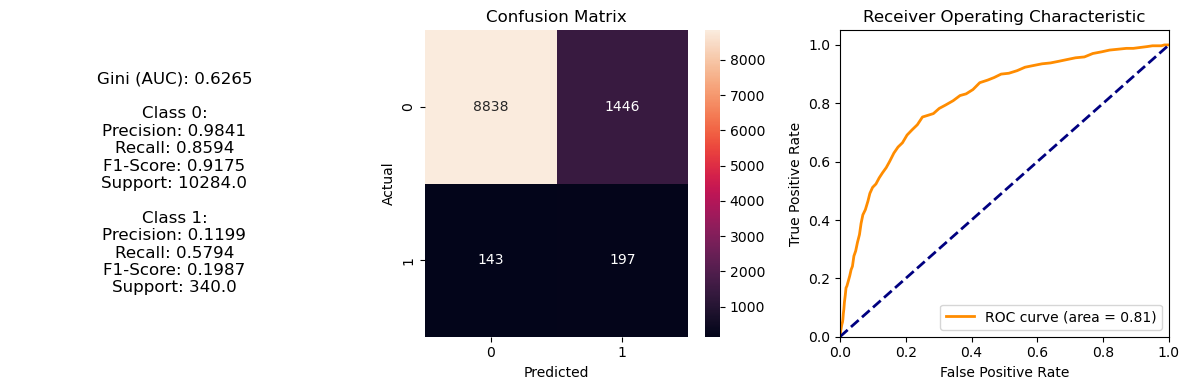


		 Analysis by Split of Feature '0' = 9


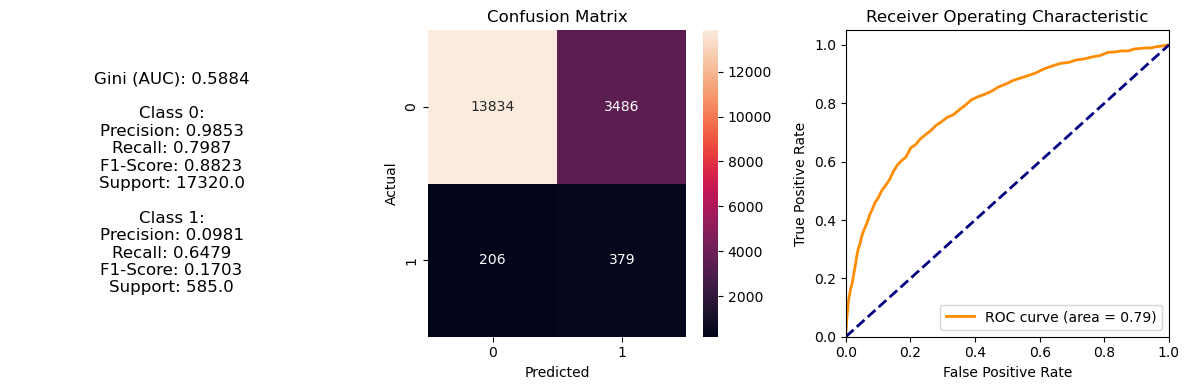


		 Analysis by Split of Feature '0' = 1


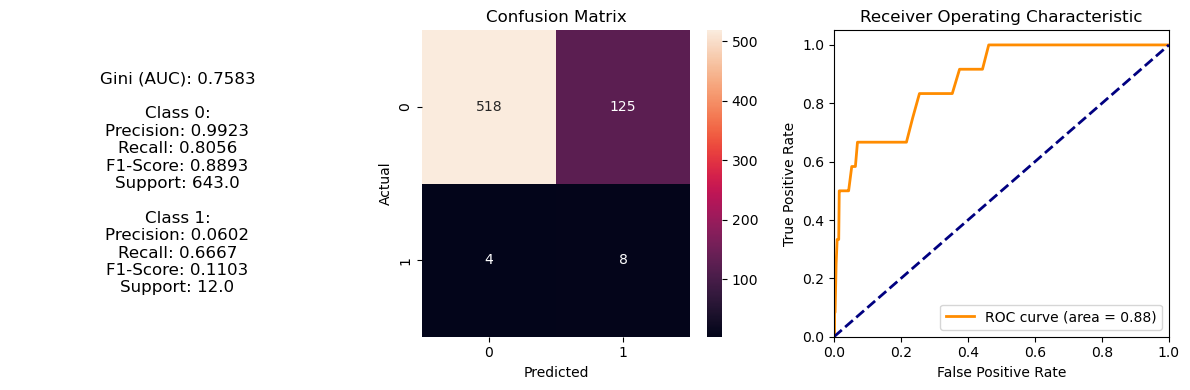

In [255]:
from imblearn.ensemble import BalancedRandomForestClassifier

model_brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=42, sampling_strategy='all', replacement=True)
model_brfc.fit(X_train, y_train)

test_check = validate(X_test, y_test, model_brfc, feature_to_analyze='0')

In [227]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


			Overall Model Evaluation


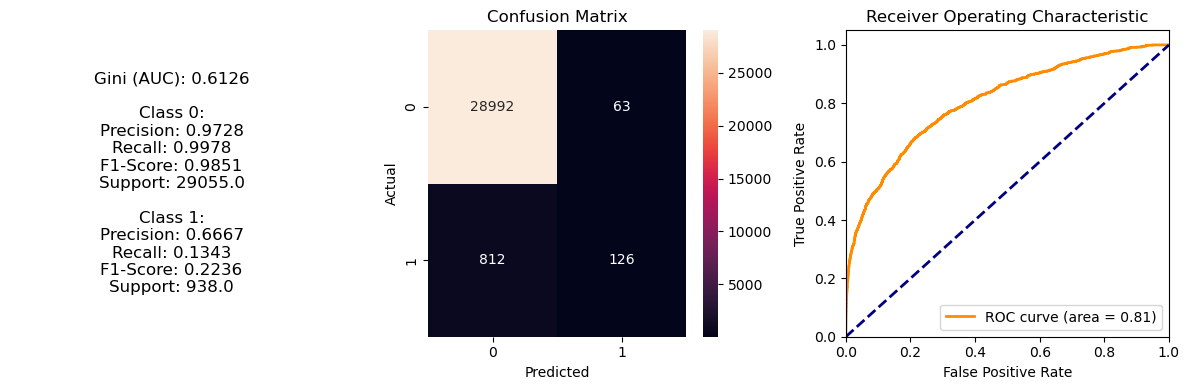


		 Analysis by Split of Feature '0' = 7


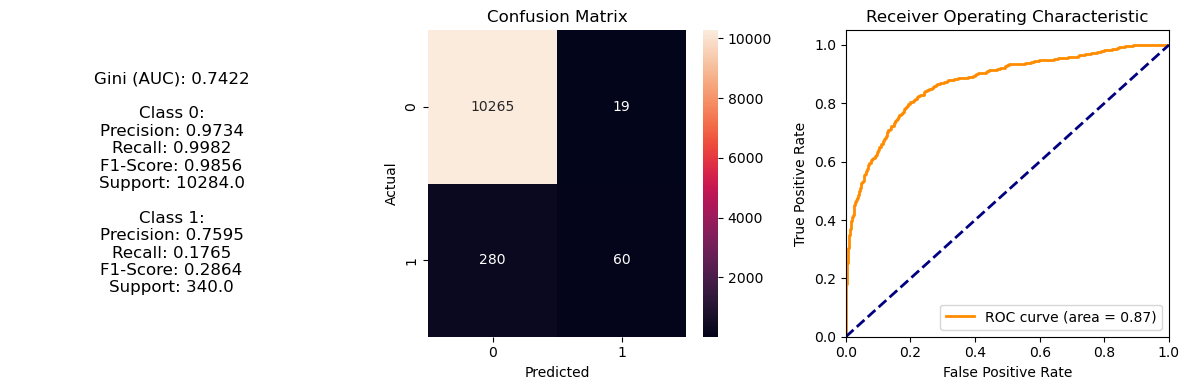


		 Analysis by Split of Feature '0' = 9


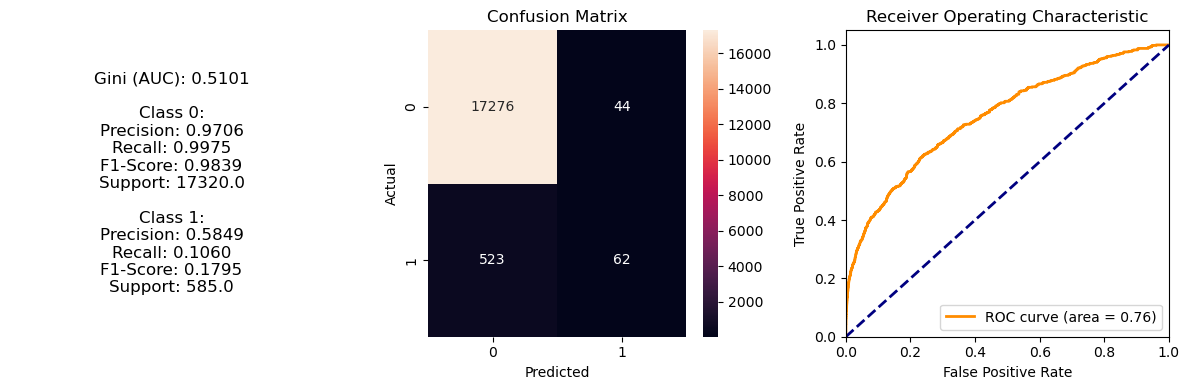


		 Analysis by Split of Feature '0' = 1


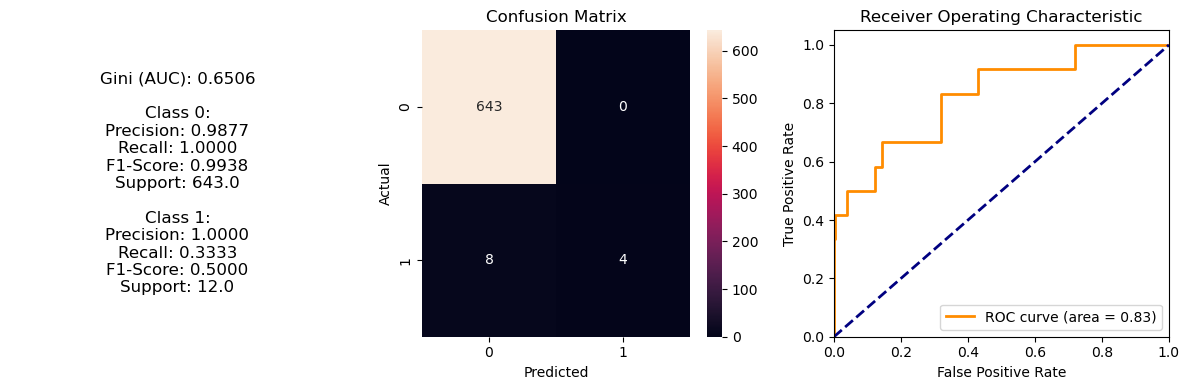

In [259]:
import xgboost as xgb
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'objective': 'binary:logistic',
    'scale_pos_weight': scale_pos_weight
}

model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train, y_train)

test_check = validate(X_test, y_test, model_xgb, feature_to_analyze='0')

## Threshold optimization

In [258]:
y_probs = model_cb.predict_proba(X_test)[:, 1]

# Перебор различных порогов
thresholds = np.arange(0.1, 1.0, 0.05) 
for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.4f}")

Threshold: 0.10, F1-Score: 0.2688
Threshold: 0.15, F1-Score: 0.2947
Threshold: 0.20, F1-Score: 0.3066
Threshold: 0.25, F1-Score: 0.3042
Threshold: 0.30, F1-Score: 0.2875
Threshold: 0.35, F1-Score: 0.2794
Threshold: 0.40, F1-Score: 0.2705
Threshold: 0.45, F1-Score: 0.2525
Threshold: 0.50, F1-Score: 0.2313
Threshold: 0.55, F1-Score: 0.2096
Threshold: 0.60, F1-Score: 0.1904
Threshold: 0.65, F1-Score: 0.1688
Threshold: 0.70, F1-Score: 0.1431
Threshold: 0.75, F1-Score: 0.1269
Threshold: 0.80, F1-Score: 0.1062
Threshold: 0.85, F1-Score: 0.0824
Threshold: 0.90, F1-Score: 0.0533
Threshold: 0.95, F1-Score: 0.0251


			Overall Model Evaluation


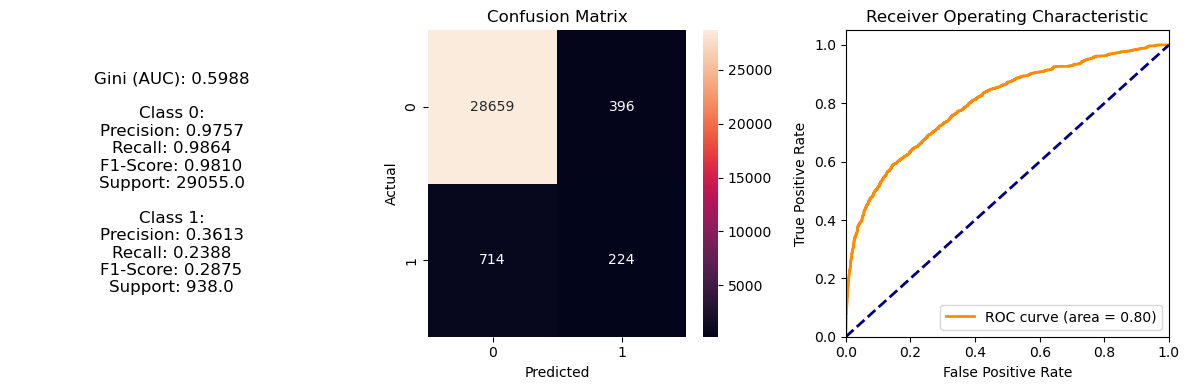


		 Analysis by Split of Feature '0' = 7


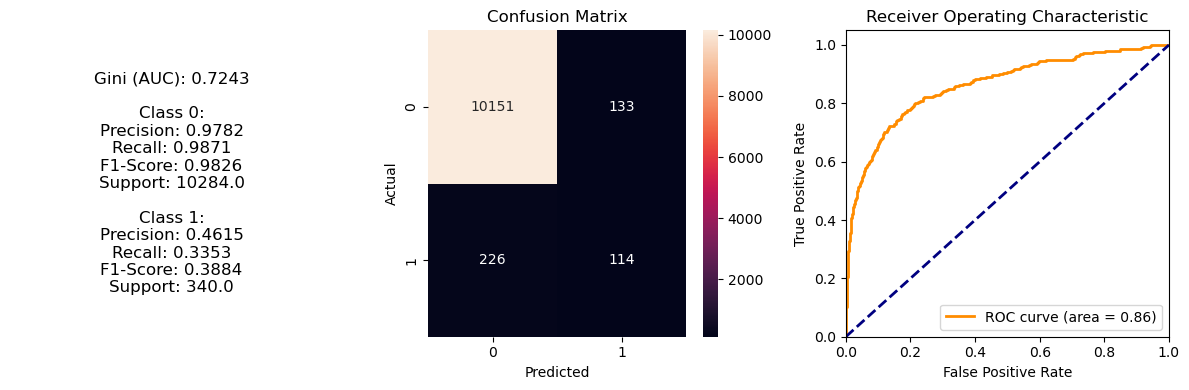


		 Analysis by Split of Feature '0' = 9


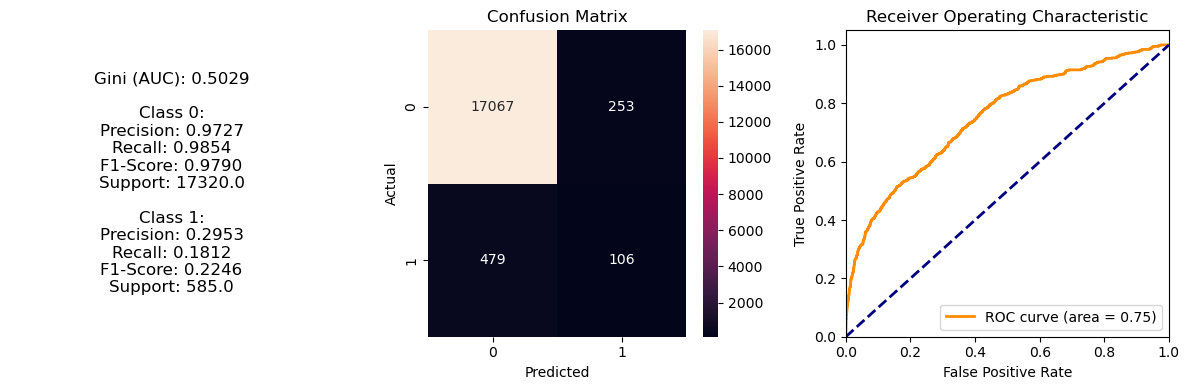


		 Analysis by Split of Feature '0' = 1


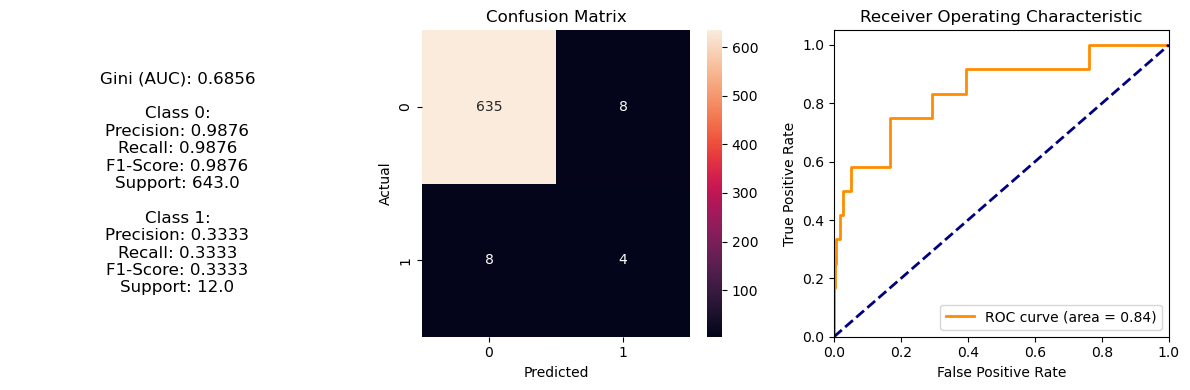

In [256]:
model_cb = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False,
                             scale_pos_weight=scale_pos_weight)
model_cb.fit(X_train, y_train)


test_check = validate(X_test, y_test, model_cb, threshold=0.3, feature_to_analyze='0') # use threshold=0.3

TODO:
 - Undersampling
 - Oversampling
 - Генерация синтетических данных(SMOTE)
 - Deep analysis

In [37]:
pip install imbalanced-learn


  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)


In [39]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
